In [15]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from PIL import Image


In [10]:
train_directory = '/content/drive/MyDrive/SDGP Y4/CW-2 implementations/pillimages/train'
validation_directory = '/content/drive/MyDrive/SDGP Y4/CW-2 implementations/pillimages/valid'

class_labels = sorted(os.listdir(train_directory))

print(class_labels)

['Amoxicillin 500 MG', 'Atomoxetine 25 MG', 'Calcitriol 0.00025 MG', 'Oseltamivir 45 MG', 'Ramipril 5 MG', 'apixaban 2.5 MG', 'aprepitant 80 MG', 'benzonatate 100 MG', 'carvedilol 3.125 MG', 'celecoxib 200 MG', 'duloxetine 30 MG', 'eltrombopag 25 MG', 'montelukast 10 MG', 'mycophenolate mofetil 250 MG', 'pantoprazole 40 MG', 'pitavastatin 1 MG', 'prasugrel 10 MG', 'saxagliptin 5 MG', 'sitagliptin 50 MG', 'tadalafil 5 MG']


In [3]:
# Define image size and batch size
IMAGE_WIDTH, IMAGE_HEIGHT = 224, 224
BATCH_SIZE = 32


In [8]:
# Set up data generators
# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # Use the ResNet50 preprocessing function
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2
)

In [4]:
# Validation data generator without augmentation
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [11]:
train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_directory,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 994 images belonging to 20 classes.
Found 274 images belonging to 20 classes.


In [12]:
# calculate the number of images per class in the training set.
from sklearn.utils.class_weight import compute_class_weight

# Calculate the weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

# Convert class weights to a dictionary to pass to model.fit
class_weights_dict = dict(enumerate(class_weights))


In [21]:
# Load the ResNet50 model, pre-trained on ImageNet data
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))

# Freeze all layers of the base model
base_model.trainable = False

# Add new layers on top of the model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
predictions = Dense(20, activation='softmax')(x)

# Final model to be trained
model = Model(inputs=base_model.input, outputs=predictions)

# Recompile the model so that the changes take effect
model.compile(optimizer=Adam(learning_rate=0.00001),  # Use a smaller learning rate for fine-tuning
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Model summary
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [22]:
# Set up checkpoints and early stopping
checkpoint = ModelCheckpoint('medscan_model.h5', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping]
)



Epoch 1/5
32/32 [==============================] - 277s 9s/step - loss: 17.2277 - accuracy: 0.0734 - val_loss: 16.3231 - val_accuracy: 0.1679
Epoch 2/5
32/32 [==============================] - 274s 9s/step - loss: 16.6039 - accuracy: 0.1398 - val_loss: 15.8305 - val_accuracy: 0.3285
Epoch 3/5
32/32 [==============================] - 273s 9s/step - loss: 16.0498 - accuracy: 0.2213 - val_loss: 15.4234 - val_accuracy: 0.4708
Epoch 4/5
32/32 [==============================] - 273s 9s/step - loss: 15.6834 - accuracy: 0.2998 - val_loss: 15.0908 - val_accuracy: 0.5365
Epoch 5/5
32/32 [==============================] - 237s 7s/step - loss: 15.3289 - accuracy: 0.3974 - val_loss: 14.7574 - val_accuracy: 0.6934


In [13]:
# Evaluate the model with the validation set
model = tf.keras.models.load_model('medscan_model.h5')
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation loss: {val_loss}, Validation accuracy: {val_accuracy}')


9/9 [==============================] - 70s 8s/step - loss: 14.8206 - accuracy: 0.7080
Validation loss: 14.820581436157227, Validation accuracy: 0.7080292105674744


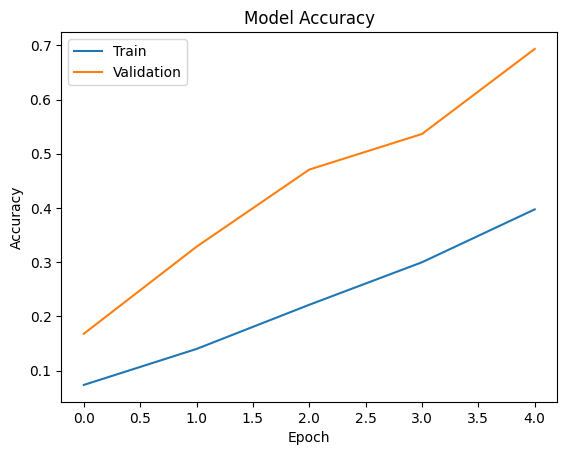

In [23]:
# Plot the training history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

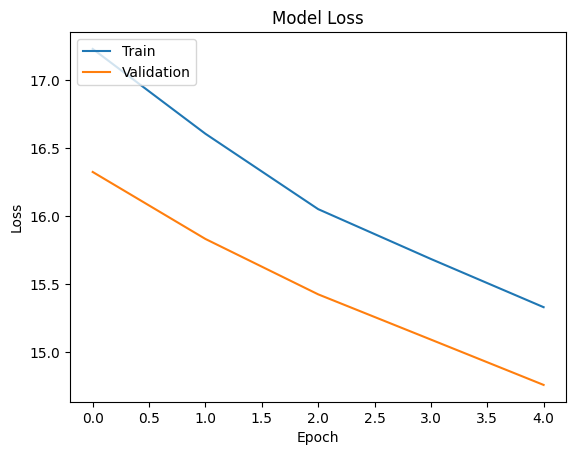

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Saving download.jpeg to download (2).jpeg
1/1 [==============================] - 1s 1s/step


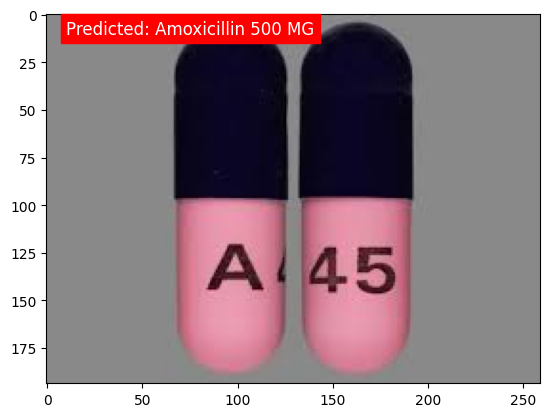

In [18]:
# Load the trained model
# model = tf.keras.models.load_model('best_model_V3.h5')

# Function to load and preprocess the image
def load_and_preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((IMAGE_WIDTH, IMAGE_HEIGHT))  # Resize the image to the expected size
    img_array = image.img_to_array(img)  # Convert the image to a numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add a batch dimension
    img_array = preprocess_input(img_array)  # Preprocess the image
    return img_array

# Function to make a prediction
def predict_image(model, processed_image):
    preds = model.predict(processed_image)
    return preds

# Code for the upload button in Google Colab
from google.colab import files
uploaded = files.upload()

image_path = next(iter(uploaded))
processed_image = load_and_preprocess_image(image_path)
predictions = predict_image(model, processed_image)

class_names = ['Amoxicillin 500 MG',
               'Atomoxetine 25 MG',
               'Calcitriol 0.00025 MG',
               'Oseltamivir 45 MG',
               'Ramipril 5 MG',
               'apixaban 2.5 MG',
               'aprepitant 80 MG',
               'benzonatate 100 MG',
               'carvedilol 3.125 MG',
               'celecoxib 200 MG',
               'duloxetine 30 MG',
               'eltrombopag 25 MG',
               'montelukast 10 MG',
               'mycophenolate mofetil 250 MG',
               'pantoprazole 40 MG',
               'pitavastatin 1 MG',
               'prasugrel 10 MG',
               'saxagliptin 5 MG',
               'sitagliptin 50 MG',
               'tadalafil 5 MG']

# Get the class with the highest probability
predicted_class = class_names[np.argmax(predictions)]

# Display the image and the prediction label
img = Image.open(image_path)
plt.imshow(img)
plt.text(10, 10, f'Predicted: {predicted_class}', fontsize=12, color='white', backgroundcolor='red')
# plt.title(f'Predicted: {predicted_class}')
plt.show()
